In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
from bart_playground import *

In [3]:
notebook = "latitude_longitude"

In [4]:
import numpy as np

from sklearn.datasets import fetch_california_housing

data = fetch_california_housing(as_frame=True)

X = data.data
y = data.target

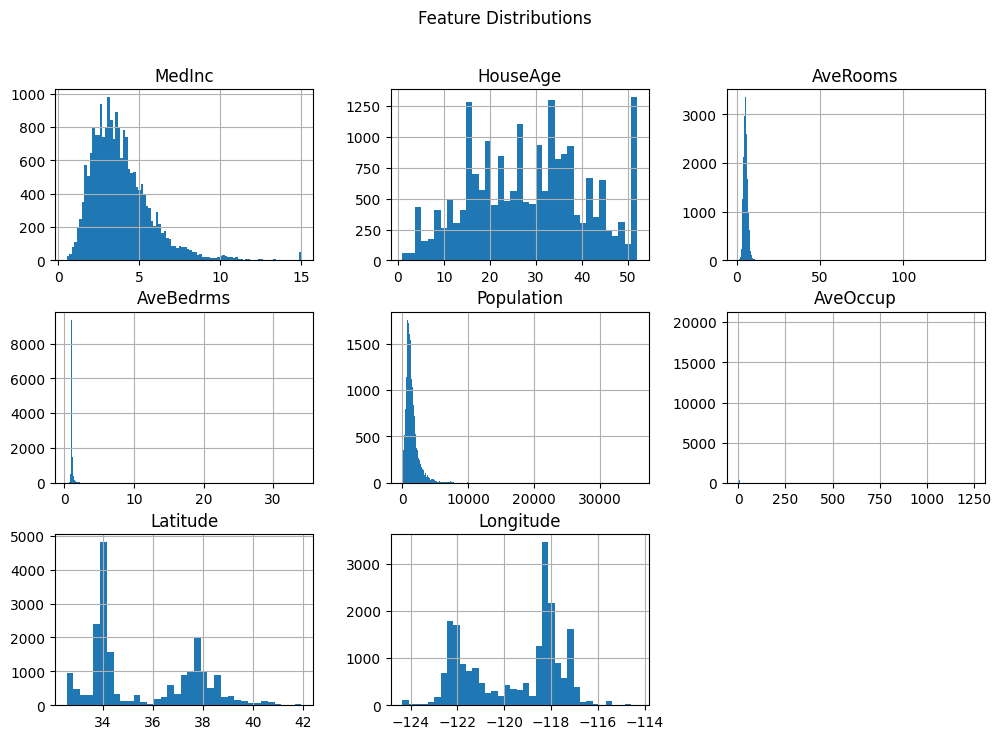

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

X.hist(figsize=(12, 8), bins='auto')
plt.suptitle("Feature Distributions")
plt.show()

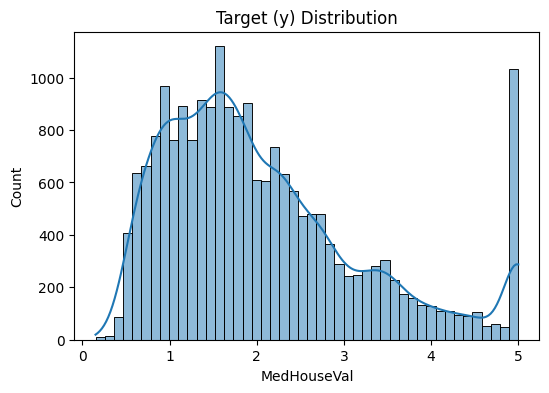

In [6]:
plt.figure(figsize=(6, 4))
sns.histplot(y, kde=True)
plt.title("Target (y) Distribution")
plt.show()

In [7]:
# Only use latitude and longitude as features
X = X[['Latitude', 'Longitude']]
print(f"Feature matrix shape: {X.shape}")

Feature matrix shape: (20640, 2)


In [8]:
X = X.values.astype(float)
y = np.array(y).reshape(-1)

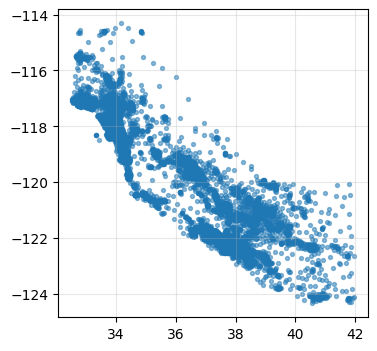

In [9]:
import matplotlib.pyplot as plt

# Scatter plot for the two features in X
plt.figure(figsize=(4, 4))
plt.scatter(X[:, 0], X[:, 1], alpha=0.5, s=8)
plt.grid(True, alpha=0.3)
plt.show()

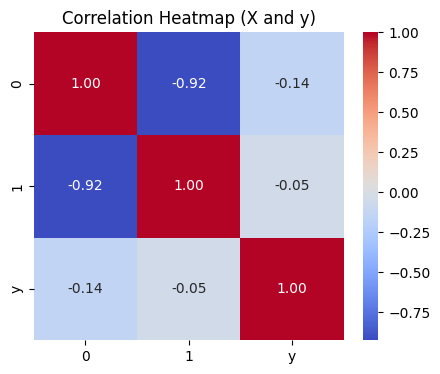

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# If X is numpy array, convert to DataFrame for correlation calculation
df = pd.DataFrame(X)
df['y'] = y

plt.figure(figsize=(5, 4))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap (X and y)")
plt.show()

In [9]:
ndpost = 2000
nskip = 0
n_trees = 100

In [10]:
from experiment_init import run_parallel_experiments

# Run 4 parallel experiments
results = run_parallel_experiments(X, y, ndpost, nskip, n_trees, notebook, n_runs=4, n_jobs=4)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
Iterations: 100%|██████████| 2000/2000 [01:16<00:00, 26.24it/s]
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed: 10.3min
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed: 10.3min remaining: 10.3min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed: 10.4min finished


In [10]:
experiment_results = np.load(f'store/{notebook}.npz', allow_pickle=True)

default_data = experiment_results['default'].item()
mtmh_data = experiment_results['mtmh'].item()
metadata = experiment_results['metadata'].item()

n_runs = metadata['n_runs']

# Trace Plots Analysis
## Tree Depth / #Leaves

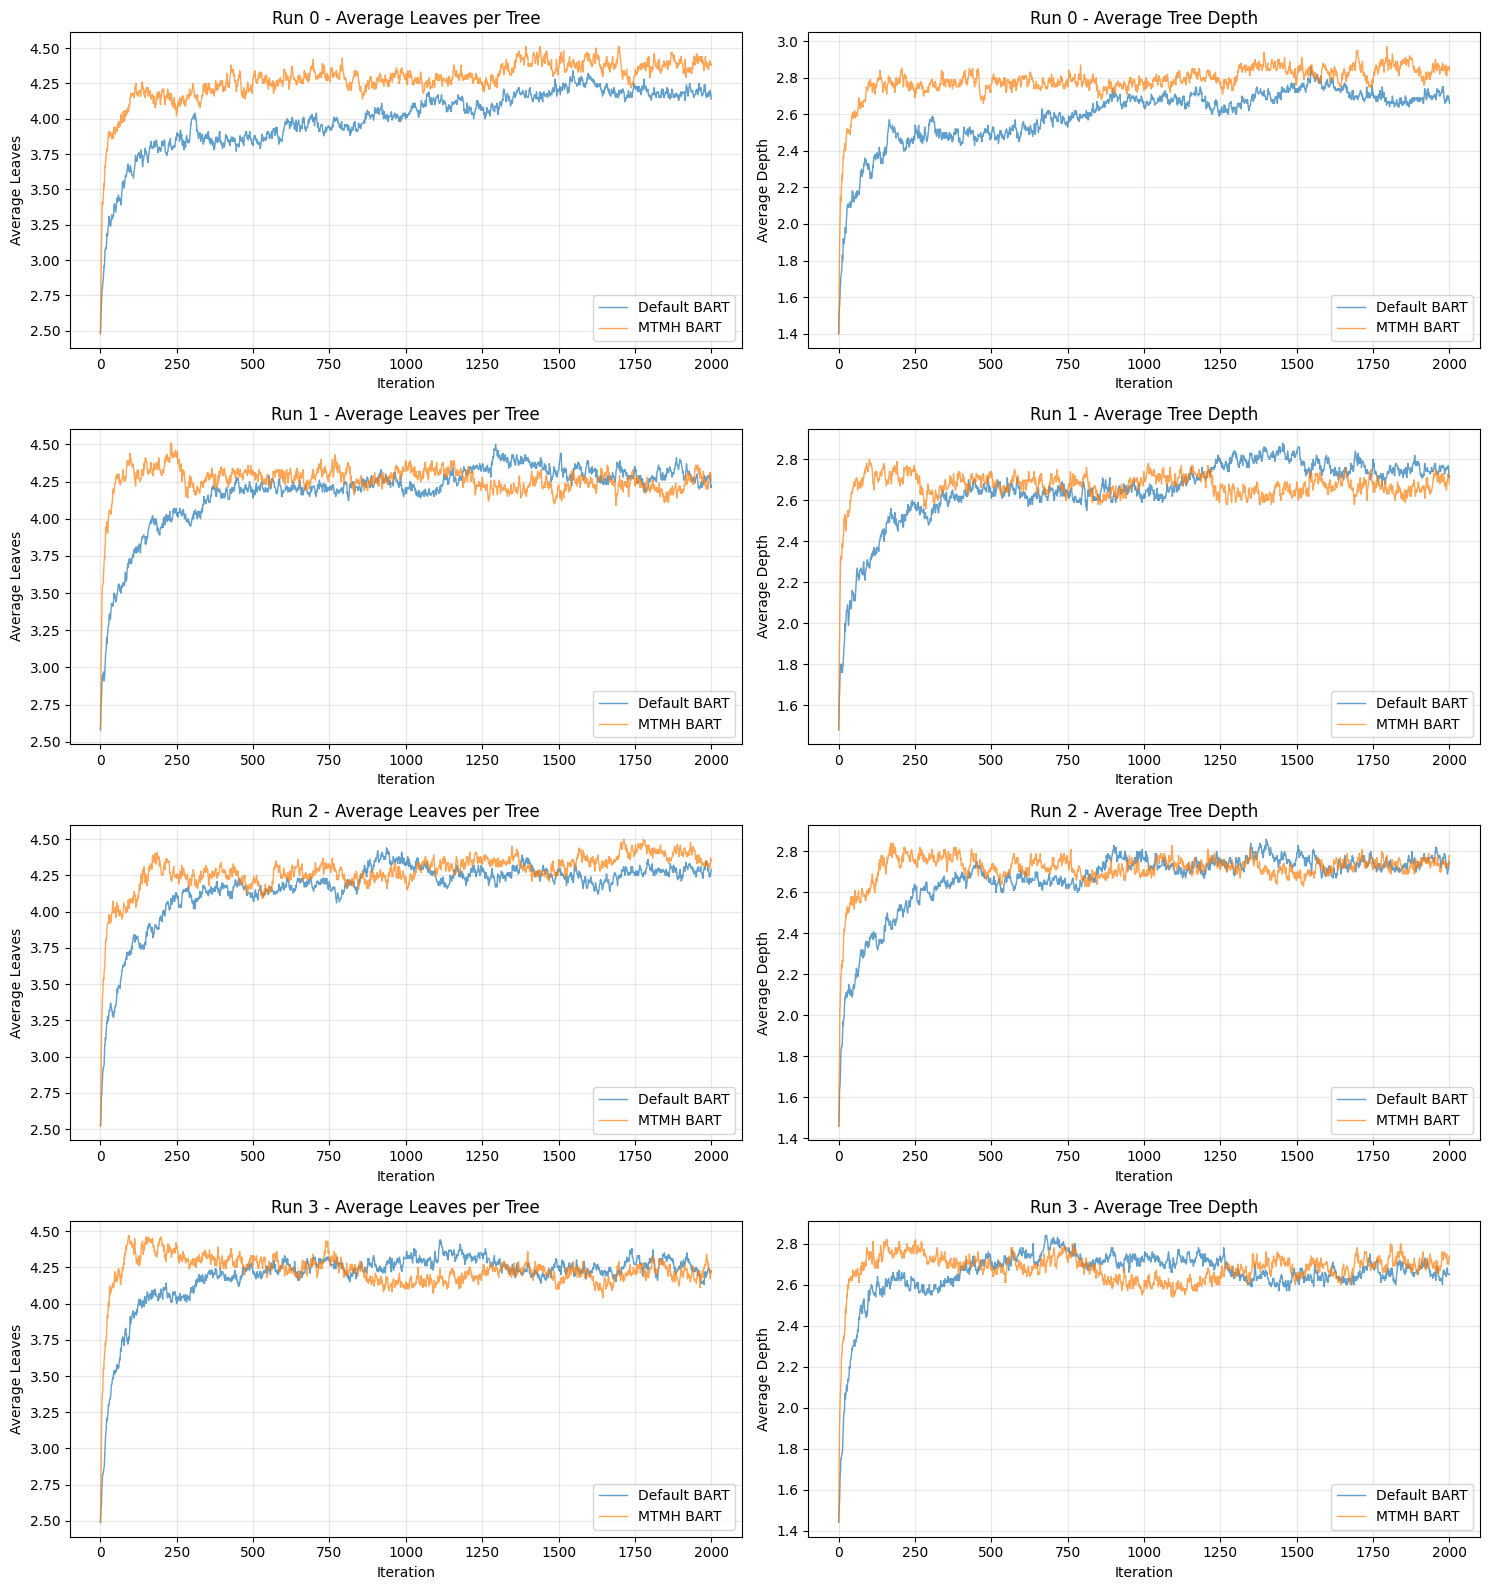

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Extract leaves and depths data for visualization
n_runs = experiment_results['metadata'].item()['n_runs']

fig, axes = plt.subplots(n_runs, 2, figsize=(15, 4*n_runs))
if n_runs == 1:
    axes = axes.reshape(1, -1)

for run_id in range(n_runs):
    # Extract data for this run
    default_leaves = experiment_results['default'].item()['leaves'][run_id]
    mtmh_leaves = experiment_results['mtmh'].item()['leaves'][run_id]
    default_depths = experiment_results['default'].item()['depths'][run_id]
    mtmh_depths = experiment_results['mtmh'].item()['depths'][run_id]
    
    # Plot leaves (left column)
    axes[run_id, 0].plot(default_leaves, label='Default BART', alpha=0.7, linewidth=1)
    axes[run_id, 0].plot(mtmh_leaves, label='MTMH BART', alpha=0.7, linewidth=1)
    axes[run_id, 0].set_title(f'Run {run_id} - Average Leaves per Tree')
    axes[run_id, 0].set_xlabel('Iteration')
    axes[run_id, 0].set_ylabel('Average Leaves')
    axes[run_id, 0].legend()
    axes[run_id, 0].grid(True, alpha=0.3)
    
    # Plot depths (right column)
    axes[run_id, 1].plot(default_depths, label='Default BART', alpha=0.7, linewidth=1)
    axes[run_id, 1].plot(mtmh_depths, label='MTMH BART', alpha=0.7, linewidth=1)
    axes[run_id, 1].set_title(f'Run {run_id} - Average Tree Depth')
    axes[run_id, 1].set_xlabel('Iteration')
    axes[run_id, 1].set_ylabel('Average Depth')
    axes[run_id, 1].legend()
    axes[run_id, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

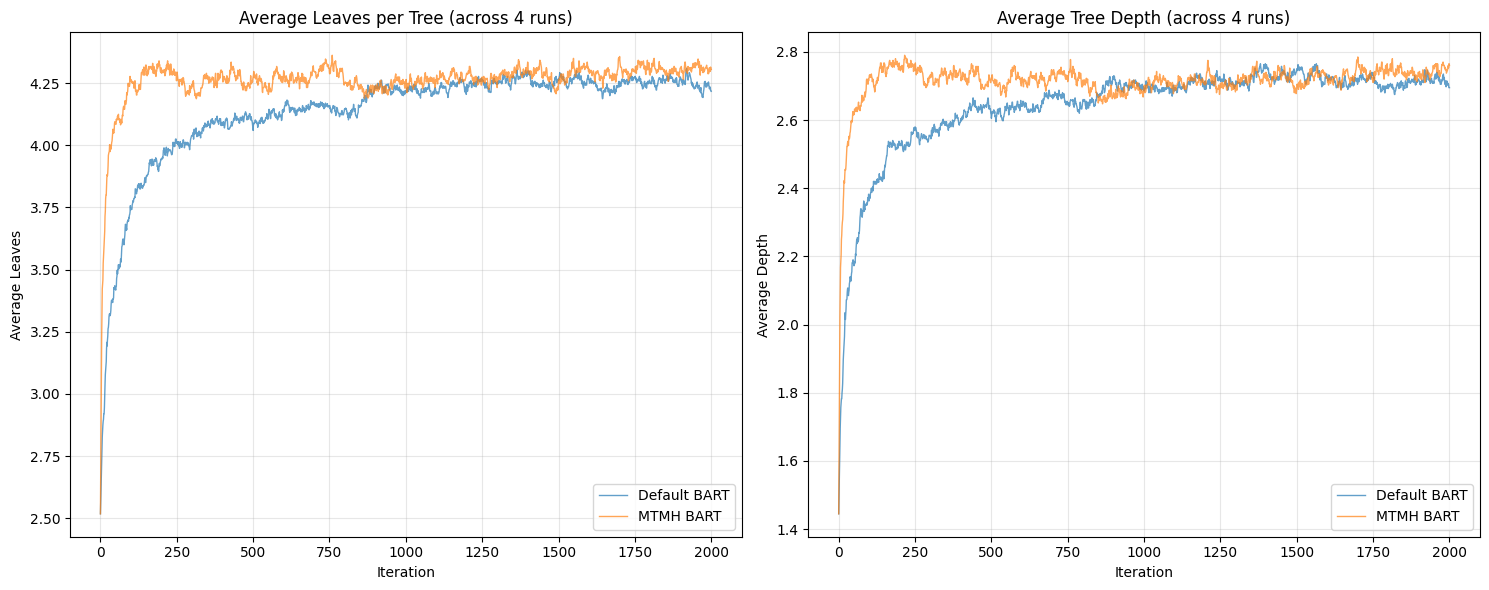

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Extract data across all runs
n_runs = experiment_results['metadata'].item()['n_runs']

# Collect all runs data
default_leaves_all = []
mtmh_leaves_all = []
default_depths_all = []
mtmh_depths_all = []

for run_id in range(n_runs):
    default_leaves_all.append(experiment_results['default'].item()['leaves'][run_id])
    mtmh_leaves_all.append(experiment_results['mtmh'].item()['leaves'][run_id])
    default_depths_all.append(experiment_results['default'].item()['depths'][run_id])
    mtmh_depths_all.append(experiment_results['mtmh'].item()['depths'][run_id])

# Convert to numpy arrays
default_leaves_all = np.array(default_leaves_all)  # Shape: (n_runs, n_iterations)
mtmh_leaves_all = np.array(mtmh_leaves_all)
default_depths_all = np.array(default_depths_all)
mtmh_depths_all = np.array(mtmh_depths_all)

# Calculate mean and std across runs
default_leaves_mean = np.mean(default_leaves_all, axis=0)
mtmh_leaves_mean = np.mean(mtmh_leaves_all, axis=0)

default_depths_mean = np.mean(default_depths_all, axis=0)
mtmh_depths_mean = np.mean(mtmh_depths_all, axis=0)

# Create iteration axis
iterations = np.arange(len(default_leaves_mean))

# Plot averaged results with error bands
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot leaves
ax1.plot(iterations, default_leaves_mean, label='Default BART', alpha=0.7, linewidth=1)
ax1.plot(iterations, mtmh_leaves_mean, label='MTMH BART', alpha=0.7, linewidth=1)
ax1.set_title(f'Average Leaves per Tree (across {n_runs} runs)')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Average Leaves')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot depths
ax2.plot(iterations, default_depths_mean, label='Default BART', alpha=0.7, linewidth=1)
ax2.plot(iterations, mtmh_depths_mean, label='MTMH BART', alpha=0.7, linewidth=1)
ax2.set_title(f'Average Tree Depth (across {n_runs} runs)')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Average Depth')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Sigmas & RMSE

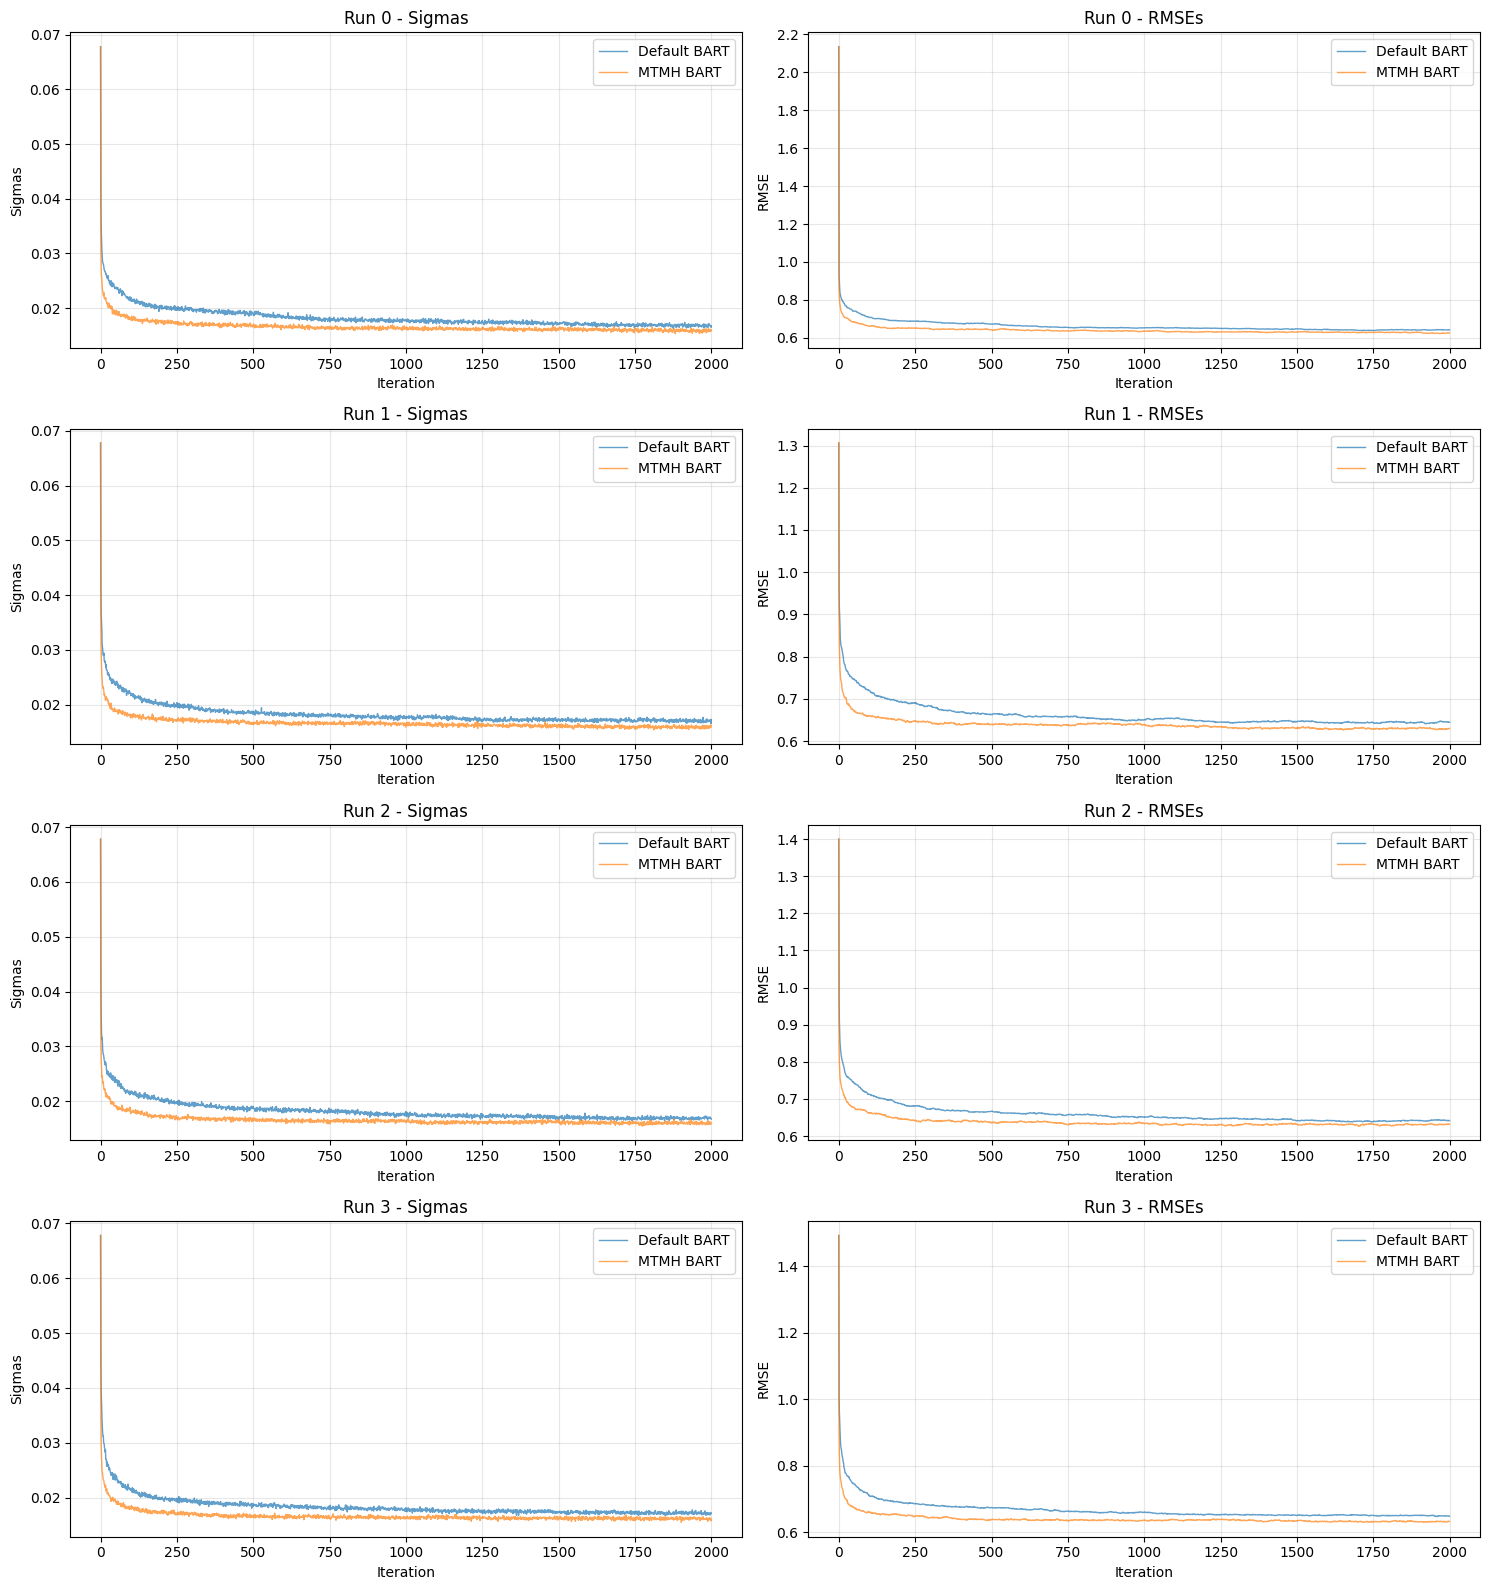

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Extract sigmas and rmses data for visualization
n_runs = experiment_results['metadata'].item()['n_runs']

fig, axes = plt.subplots(n_runs, 2, figsize=(15, 4*n_runs))
if n_runs == 1:
    axes = axes.reshape(1, -1)

for run_id in range(n_runs):
    # Extract data for this run
    default_sigmas = experiment_results['default'].item()['sigmas'][run_id]
    mtmh_sigmas = experiment_results['mtmh'].item()['sigmas'][run_id]
    default_rmses = experiment_results['default'].item()['rmses'][run_id]
    mtmh_rmses = experiment_results['mtmh'].item()['rmses'][run_id]

    # Plot sigmas (left column)
    axes[run_id, 0].plot(default_sigmas, label='Default BART', alpha=0.7, linewidth=1)
    axes[run_id, 0].plot(mtmh_sigmas, label='MTMH BART', alpha=0.7, linewidth=1)
    axes[run_id, 0].set_title(f'Run {run_id} - Sigmas')
    axes[run_id, 0].set_xlabel('Iteration')
    axes[run_id, 0].set_ylabel('Sigmas')
    axes[run_id, 0].legend()
    axes[run_id, 0].grid(True, alpha=0.3)

    # Plot rmses (right column)
    axes[run_id, 1].plot(default_rmses, label='Default BART', alpha=0.7, linewidth=1)
    axes[run_id, 1].plot(mtmh_rmses, label='MTMH BART', alpha=0.7, linewidth=1)
    axes[run_id, 1].set_title(f'Run {run_id} - RMSEs')
    axes[run_id, 1].set_xlabel('Iteration')
    axes[run_id, 1].set_ylabel('RMSE')
    axes[run_id, 1].legend()
    axes[run_id, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

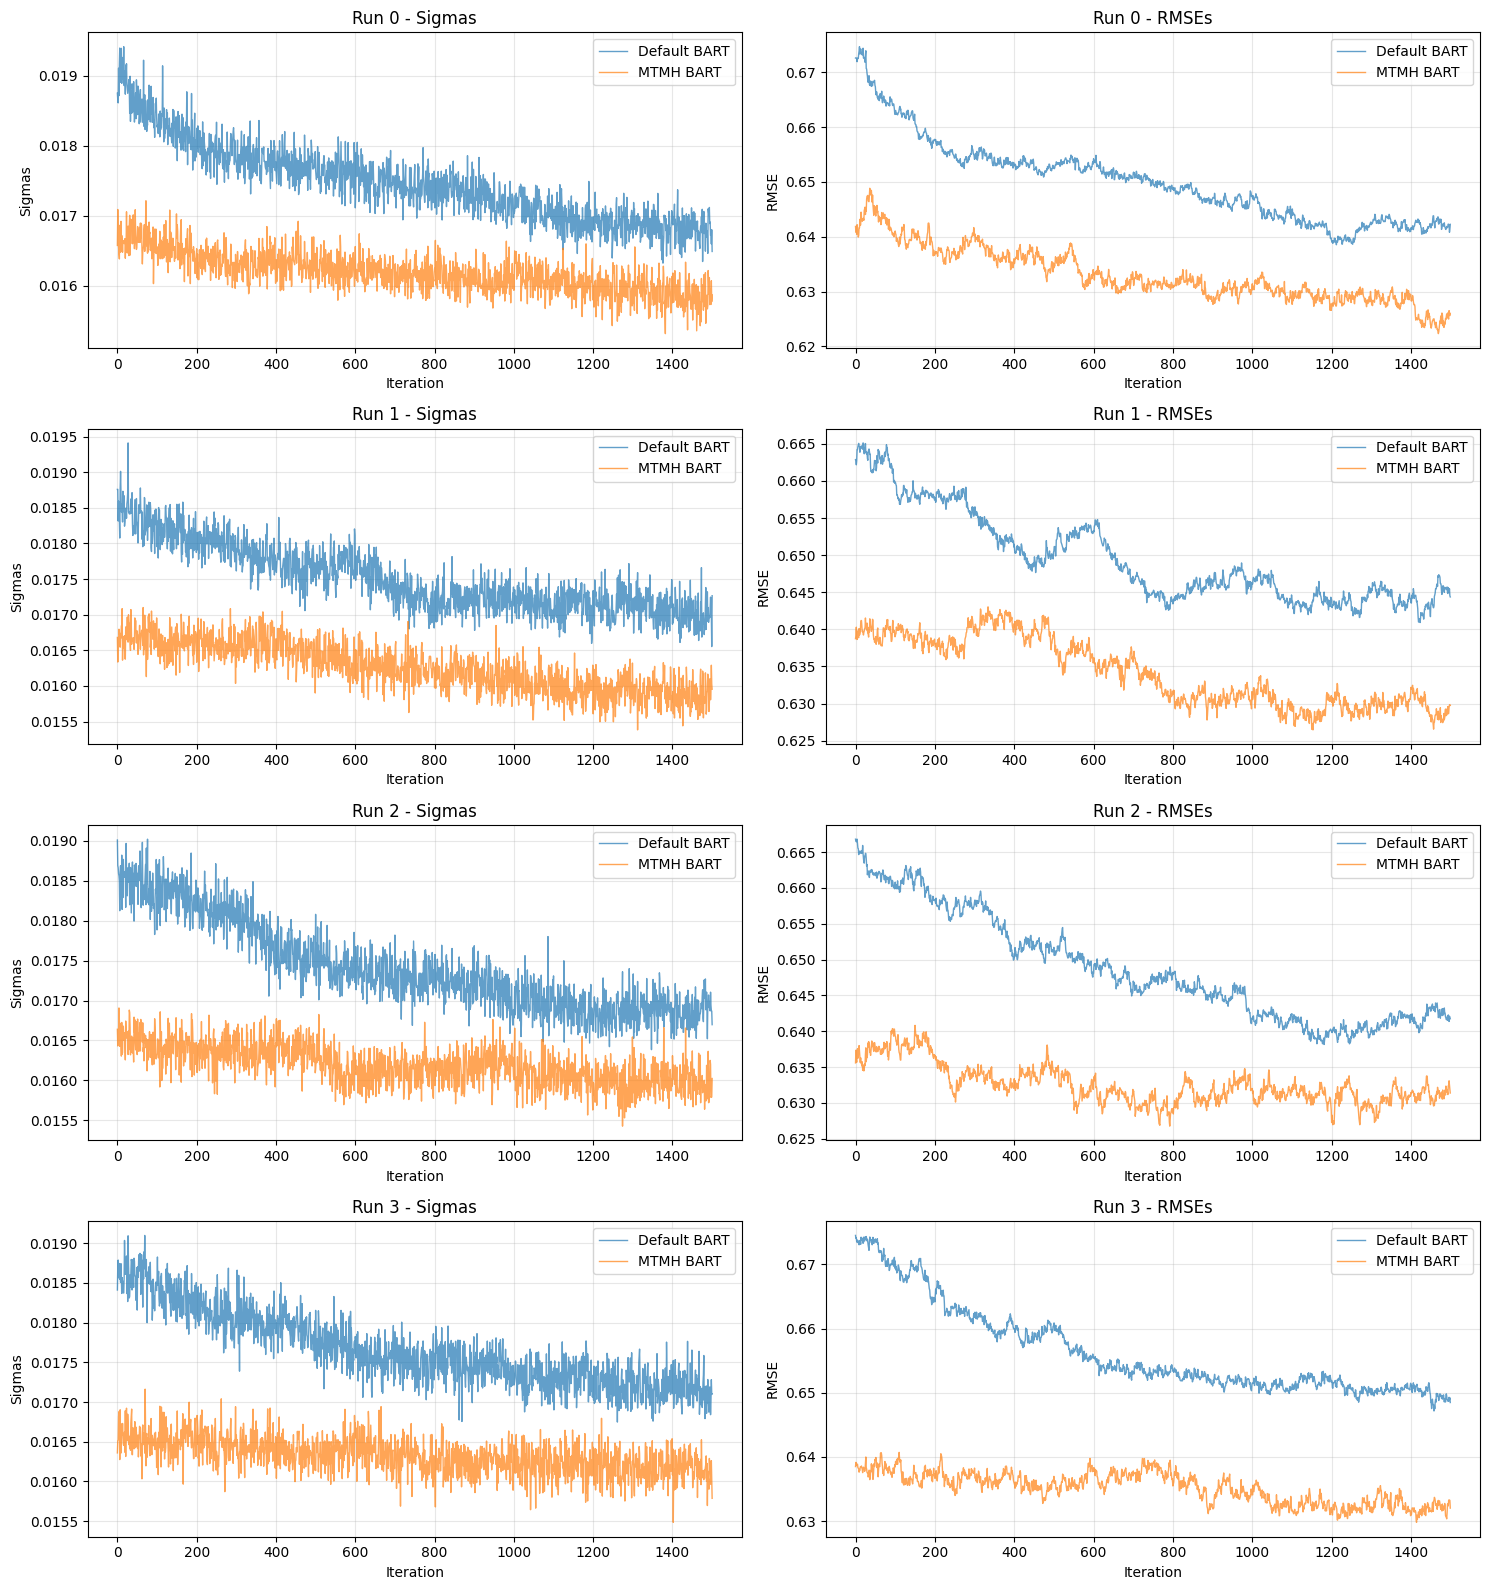

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Extract sigmas and rmses data for visualization
n_runs = experiment_results['metadata'].item()['n_runs']

fig, axes = plt.subplots(n_runs, 2, figsize=(15, 4*n_runs))
if n_runs == 1:
    axes = axes.reshape(1, -1)

for run_id in range(n_runs):
    # Extract data for this run
    default_sigmas = experiment_results['default'].item()['sigmas'][run_id]
    mtmh_sigmas = experiment_results['mtmh'].item()['sigmas'][run_id]
    default_rmses = experiment_results['default'].item()['rmses'][run_id]
    mtmh_rmses = experiment_results['mtmh'].item()['rmses'][run_id]

    # Plot sigmas (left column)
    axes[run_id, 0].plot(default_sigmas[500:], label='Default BART', alpha=0.7, linewidth=1)
    axes[run_id, 0].plot(mtmh_sigmas[500:], label='MTMH BART', alpha=0.7, linewidth=1)
    axes[run_id, 0].set_title(f'Run {run_id} - Sigmas')
    axes[run_id, 0].set_xlabel('Iteration')
    axes[run_id, 0].set_ylabel('Sigmas')
    axes[run_id, 0].legend()
    axes[run_id, 0].grid(True, alpha=0.3)

    # Plot rmses (right column)
    axes[run_id, 1].plot(default_rmses[500:], label='Default BART', alpha=0.7, linewidth=1)
    axes[run_id, 1].plot(mtmh_rmses[500:], label='MTMH BART', alpha=0.7, linewidth=1)
    axes[run_id, 1].set_title(f'Run {run_id} - RMSEs')
    axes[run_id, 1].set_xlabel('Iteration')
    axes[run_id, 1].set_ylabel('RMSE')
    axes[run_id, 1].legend()
    axes[run_id, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

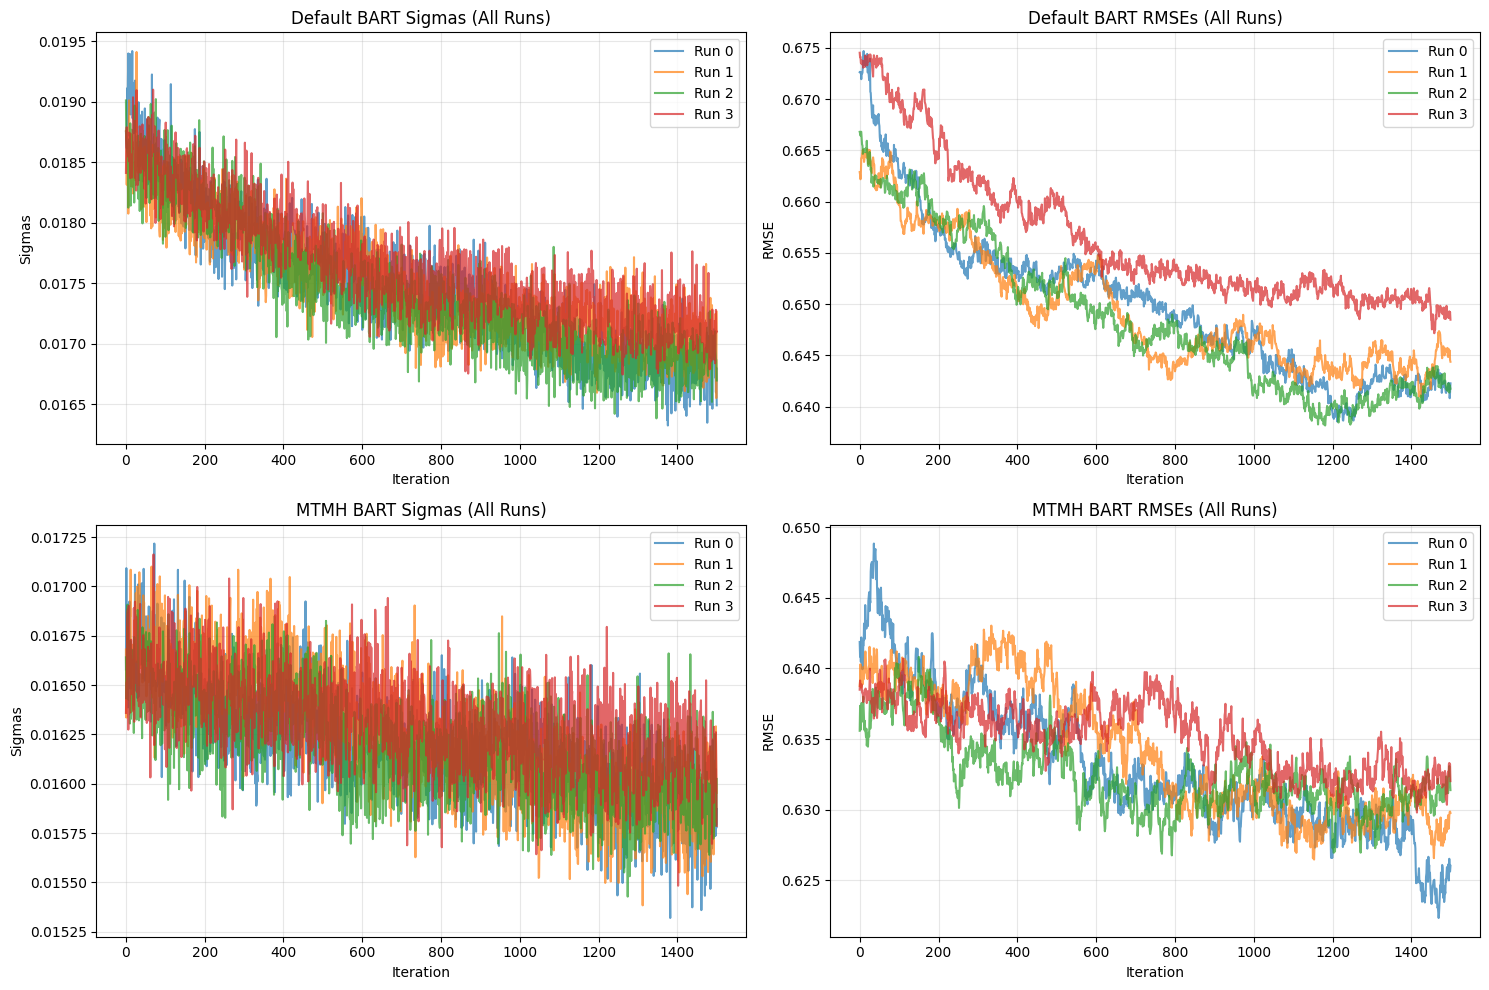

In [11]:
import matplotlib.pyplot as plt
import numpy as np

n_runs = experiment_results['metadata'].item()['n_runs']

default_sigmas_all = []
mtmh_sigmas_all = []
default_rmses_all = []
mtmh_rmses_all = []

for run_id in range(n_runs):
    default_sigmas_all.append(experiment_results['default'].item()['sigmas'][run_id][500:])
    mtmh_sigmas_all.append(experiment_results['mtmh'].item()['sigmas'][run_id][500:])
    default_rmses_all.append(experiment_results['default'].item()['rmses'][run_id][500:])
    mtmh_rmses_all.append(experiment_results['mtmh'].item()['rmses'][run_id][500:])

default_sigmas_all = np.array(default_sigmas_all)
mtmh_sigmas_all = np.array(mtmh_sigmas_all)
default_rmses_all = np.array(default_rmses_all)
mtmh_rmses_all = np.array(mtmh_rmses_all)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

iterations = np.arange(default_sigmas_all.shape[1])
# Top left: Default BART sigmas (all runs)
for run_id in range(n_runs):
    axes[0, 0].plot(iterations, default_sigmas_all[run_id], label=f'Run {run_id}', alpha=0.7)
axes[0, 0].set_title('Default BART Sigmas (All Runs)')
axes[0, 0].set_xlabel('Iteration')
axes[0, 0].set_ylabel('Sigmas')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Bottom left: MTMH BART sigmas (all runs)
for run_id in range(n_runs):
    axes[1, 0].plot(iterations, mtmh_sigmas_all[run_id], label=f'Run {run_id}', alpha=0.7)
axes[1, 0].set_title('MTMH BART Sigmas (All Runs)')
axes[1, 0].set_xlabel('Iteration')
axes[1, 0].set_ylabel('Sigmas')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

iterations = np.arange(default_rmses_all.shape[1])
# Top right: Default BART RMSEs (all runs)
for run_id in range(n_runs):
    axes[0, 1].plot(iterations, default_rmses_all[run_id], label=f'Run {run_id}', alpha=0.7)
axes[0, 1].set_title('Default BART RMSEs (All Runs)')
axes[0, 1].set_xlabel('Iteration')
axes[0, 1].set_ylabel('RMSE')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Bottom right: MTMH BART RMSEs (all runs)
for run_id in range(n_runs):
    axes[1, 1].plot(iterations, mtmh_rmses_all[run_id], label=f'Run {run_id}', alpha=0.7)
axes[1, 1].set_title('MTMH BART RMSEs (All Runs)')
axes[1, 1].set_xlabel('Iteration')
axes[1, 1].set_ylabel('RMSE')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

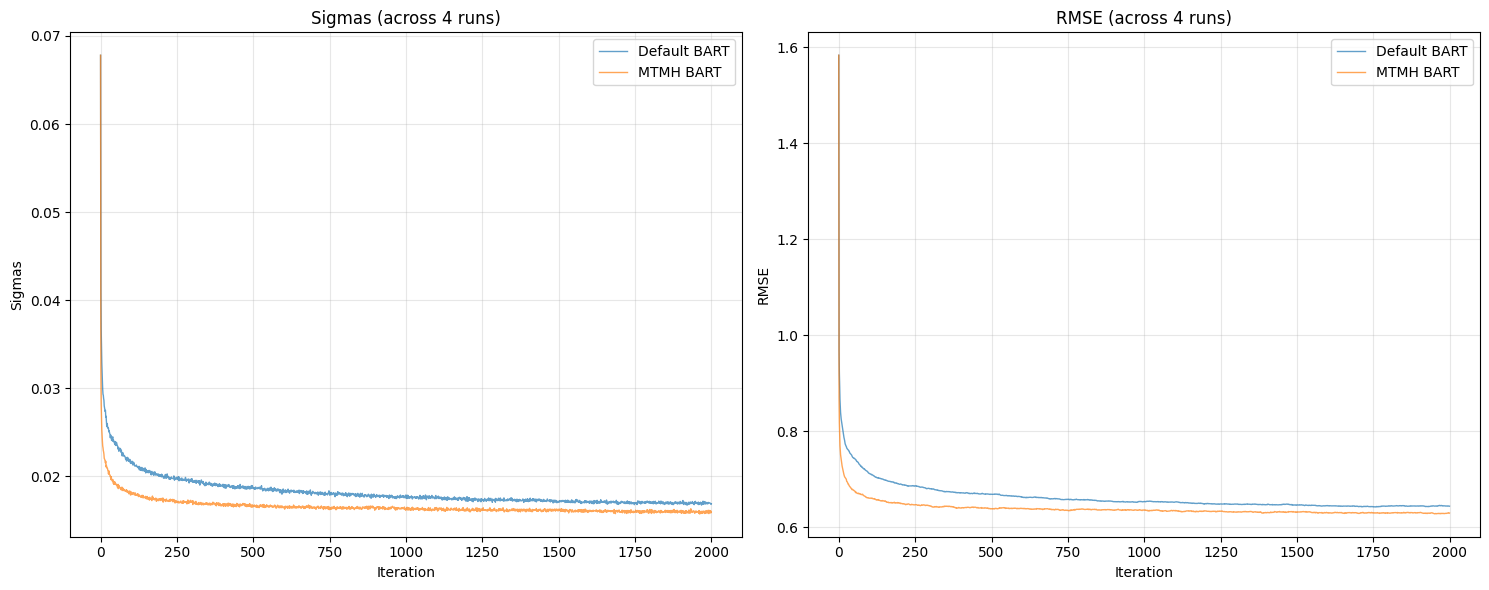

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Extract data across all runs
n_runs = experiment_results['metadata'].item()['n_runs']

# Collect all runs data
default_sigmas_all = []
mtmh_sigmas_all = []
default_rmses_all = []
mtmh_rmses_all = []

for run_id in range(n_runs):
    default_sigmas_all.append(experiment_results['default'].item()['sigmas'][run_id])
    mtmh_sigmas_all.append(experiment_results['mtmh'].item()['sigmas'][run_id])
    default_rmses_all.append(experiment_results['default'].item()['rmses'][run_id])
    mtmh_rmses_all.append(experiment_results['mtmh'].item()['rmses'][run_id])

# Convert to numpy arrays
default_sigmas_all = np.array(default_sigmas_all)  # Shape: (n_runs, n_iterations)
mtmh_sigmas_all = np.array(mtmh_sigmas_all)
default_rmses_all = np.array(default_rmses_all)
mtmh_rmses_all = np.array(mtmh_rmses_all)

# Calculate mean and std across runs
default_sigmas_mean = np.mean(default_sigmas_all, axis=0)
mtmh_sigmas_mean = np.mean(mtmh_sigmas_all, axis=0)

default_rmses_mean = np.mean(default_rmses_all, axis=0)
mtmh_rmses_mean = np.mean(mtmh_rmses_all, axis=0)

# Plot averaged results with error bands
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot sigmas
iterations = np.arange(len(default_sigmas_mean))
ax1.plot(iterations, default_sigmas_mean, label='Default BART', alpha=0.7, linewidth=1)
ax1.plot(iterations, mtmh_sigmas_mean, label='MTMH BART', alpha=0.7, linewidth=1)
ax1.set_title(f'Sigmas (across {n_runs} runs)')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Sigmas')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot rmses
iterations = np.arange(len(default_rmses_mean))
ax2.plot(iterations, default_rmses_mean, label='Default BART', alpha=0.7, linewidth=1)
ax2.plot(iterations, mtmh_rmses_mean, label='MTMH BART', alpha=0.7, linewidth=1)
ax2.set_title(f'RMSE (across {n_runs} runs)')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('RMSE')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

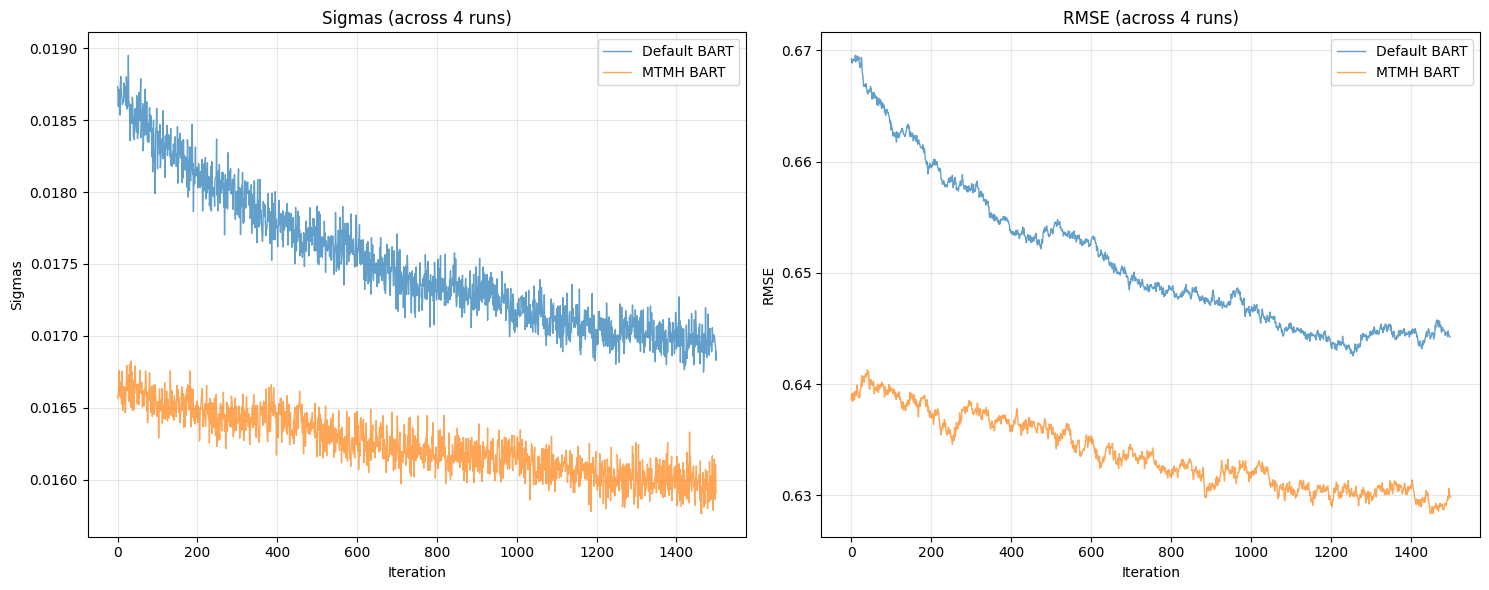

In [17]:
# Extract data after burn-in
default_sigmas_mean = default_sigmas_mean[500:]
mtmh_sigmas_mean = mtmh_sigmas_mean[500:]

default_rmses_mean = default_rmses_mean[500:]
mtmh_rmses_mean = mtmh_rmses_mean[500:]

# Plot averaged results with error bands
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot sigmas
iterations = np.arange(len(default_sigmas_mean))
ax1.plot(iterations, default_sigmas_mean, label='Default BART', alpha=0.7, linewidth=1)
ax1.plot(iterations, mtmh_sigmas_mean, label='MTMH BART', alpha=0.7, linewidth=1)
ax1.set_title(f'Sigmas (across {n_runs} runs)')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Sigmas')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot rmses
iterations = np.arange(len(default_rmses_mean))
ax2.plot(iterations, default_rmses_mean, label='Default BART', alpha=0.7, linewidth=1)
ax2.plot(iterations, mtmh_rmses_mean, label='MTMH BART', alpha=0.7, linewidth=1)
ax2.set_title(f'RMSE (across {n_runs} runs)')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('RMSE')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()